---
title: Predictive vs. explanatory regression
teaching: 45
exercises: 2
keypoints:
- "Linear regression models can be used to predict a target variable and/or to reveal relationships between variables"
- "Linear models are most effective when applied to linear relationships. Data transformation techniques can be used to help ensure that only linear relationships are modelled."
- "Train/test splits are used to assess under/overfitting in a model"
- "Different model evaluation metrics provide different perspectives of model error. Some error measurements, such as R-squared, are not as relevant for explanatory models."
objectives:
- "Review structure and goals of linear regression"
- "Know when to use different model evaluation metrics for different modeling goals"
- "Learn how to train and evaluate a predictive machine learning model"
- "Understand how to detect underfitting and overfitting in a machine learning model"
questions:
- "What are the two different goals to keep in mind when fitting machine learning models?"
- "What kinds of questions can be answered using linear regresion?"
- "How can we evaluate a model's ability to capture a true signal/relationship in the data versus spurious noise?"
---

## Goals of Linear Regression
Linear regression is powerful technique that is often used to understand whether and how certain *predictor variables* (e.g., garage size, year built, etc.) in a dataset **linearly relate** to some *target variable* (e.g., house sale prices). By modeling these relationships in the housing data, we can:

1. **Predict**: Use predictive modeling to predict hypothetical/future sale prices based on observed values of the predictor variables in our dataset (e.g., garage size, year built, etc.).
2. **Explain**: Use statistics to make scientific claims concerning which predictor variables have a significant impact on sale price — the target variable

In this workshop, we will explore how we can exploit well-established machine learning methods, including *feature selection*, and *regularization techniques* (more on these terms later), to achieve both of the above goals on high-dimensional datasets.

#### EXERCISE_START: To predict or explain. That is the question.
When trying to model data you use in your work, which goal is typically more prevalent? Do you typically care more about (1) accurately predicting some target variable or (2) making scientific claims concerning the existence of certain relationships between variables?
#### EXERCISE_SOLUTION
In a research setting, explaining relationships typically takes higher priority over predicting since explainations hold high value in science, but both goals are sometimes relevant. In industry, the reverse is typically true as many industry applications place predictive accuracy above explainability. We will explore how these goals align and sometimes diverge from one another throughout the remaining lessons.
#### EXERCISE_END

### Predicting housing prices with a single predictor
We'll start with the first goal: prediction. How can we use regression models to predict housing sale prices? For clarity, we will begin this question through the lens of simple univariate regression models.

We'll start by loading in the Ames housing data as we have done previously in this workshop.

In [1]:
# See here for thorough documentation regarding the feature set: 
# https://www.openml.org/d/42165
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True) #

C:\Users\Endemann\anaconda3\envs\highdim_workshop\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


##### Reminder of basic data properties
1. How many observations and features are there in the data? 
2. What are some of the features available?
3. What is the name of the target feature?

In [2]:
print(f"housing['data'].shape = {housing['data'].shape}\n") # 80 features total, 1460 observations
print(f"housing['feature_names'] = {housing['feature_names']}\n")
print(f"housing['target_names'] = {housing['target_names']}\n")

housing['data'].shape = (1460, 80)

housing['feature_names'] = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'E

#### 2) Extract predictor variable and target variable from dataframe
Next, we'll extract the two variables we'll use for our model — the target variable that we'll attempt to predict (SalePrice), and a single predictor variable that will be used to predict the target variable. For this example, we'll explore how well the "YearBuilt" variable (i.e., the predictor variable) can predict sale prices. 

In [3]:
# Extract x (single predictor variable = YearBuilt) and y (target variable = SalePrice)
y = housing['target']
predictor = 'OverallQual'#'TotalBsmtSF'#'GarageArea'
x = housing['data'][predictor]

#### 3) Visualize the relationship between x and y
Before fitting any models in a univariate context, we should first explore the data to get a sense for the relationship between the predictor variable, "YearBuilt", and the response variable, "SalePrice". If this relationship does not look linear, we won't be able to fit a good linear model (i.e., a model with low average prediction error in a predictive modeling context) to the data.

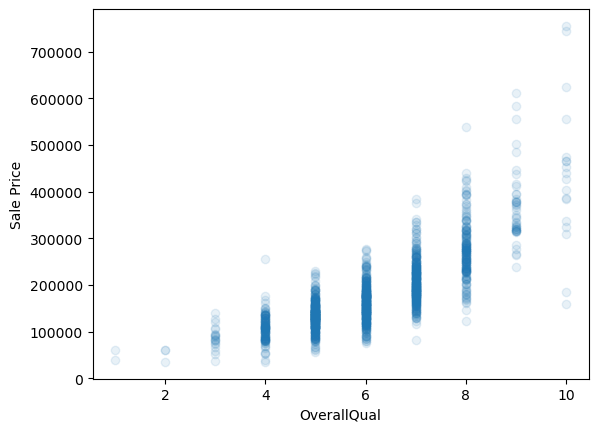

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x,y, alpha=.1)
plt.xlabel(predictor)
plt.ylabel('Sale Price');
plt.savefig('..//fig//regression//scatterplot_x_vs_salePrice.png', bbox_inches='tight', dpi=300, facecolor='white');

<img src="../fig/regression/scatterplot_x_vs_salePrice.png"  align="center" width="30%" height="30%">

Unfortunately, sale price appears to grow almost exponentially—not linearly—with the predictor variable. Any line we draw through this data cloud is going to fail in capturing the true trend we see here. 

##### Log scaling
How can we remedy this situation? One common approach is to log transform the target variable. We’ll convert the "SalePrice" variable to its logarithmic form by using the math.log() function. Pandas has a special function called apply which can apply an operation to every item in a series by using the statement y.apply(math.log), where y is a pandas series.

In [5]:
import numpy as np
y_log = y.apply(np.log)

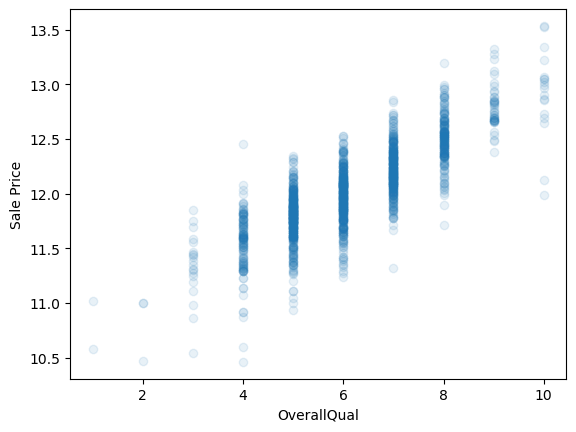

In [6]:
plt.scatter(x,y_log, alpha=.1)
plt.xlabel(predictor)
plt.ylabel('Sale Price');
plt.savefig('..//fig//regression//scatterplot_x_vs_logSalePrice.png', bbox_inches='tight', dpi=300, facecolor='white')

<img src="../fig/regression/scatterplot_x_vs_logSalePrice.png"  align="center" width="30%" height="30%">

This plot looks much better than the previous one. That is, the trend between the predictor and "SalePrice" appears somewhat more linear. Whether or not it is sufficiently linear can be addressed when we evaluate the model's performance later.

#### 3) Train/test split
Next, we will prepare two subsets of our data to be used for "model-fitting" and "model evaluation". This process is standard for any predictive modeling task that involves a model "learning" from observed data (e.g., fitting a line to the observed data).

During the model-fitting step, we use a subset of the data referred to as **training data** to estimate the model's coefficients (the slope of the model). The univariate model will find a line of best fit through this data. 

Next, we can assess the model's ability to generalize to new datasets by measuring its performance on the remaining, unseen data. This subset of data is referred to as the **test data** or holdout set. By evaluating the model on the test set, which was not used during training, we can obtain an unbiased estimate of the model's performance.

If we were to evaluate the model solely on the training data, it could lead to **overfitting**. Overfitting occurs when the model learns the noise and specific patterns of the training data too well, resulting in poor performance on new data. By using a separate test set, we can identify if the model has overfit the training data and assess its ability to generalize to unseen samples. While overfitting is typically not likely to occur when using only a single predictor variable, it is still a good idea to use a train/test split when fitting univariate models. This can help in detecting unanticipated issues with the data, such as missing values, outliers, or other anomalies that affect the model's behavior.

![The above image is from Badillo et al., 2020. An Introduction to Machine Learning. Clinical Pharmacology & Therapeutics. 107. 10.1002/cpt.1796.](../fig/regression/under_v_over_fit.png)


The below code will split our dataset into a training dataset containing 2/3 of the samples, and a test set containing the remaining 1/3 of the data. We'll discuss these different subsets in more detail in just a bit.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_log, 
                                                    test_size=0.33, 
                                                    random_state=0)

print(x_train.shape)
print(x_test.shape)

(978,)
(482,)


Reshape single-var predictor matrix in preparation for model-fitting step (requires a 2-D representation)

In [8]:
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
print(x_train.shape)
print(x_test.shape)

(978, 1)
(482, 1)


#### 4) Fit the model to the training dataset

During the model fitting step, we use a subset of the data referred to as **training data** to estimate the model's coefficients. The univariate model will find a line of best fit through this data.

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train,y_train)

#### 5) Get model predictions for train and test data

In [10]:
y_pred_train=reg.predict(x_train)
y_pred_test=reg.predict(x_test)

#### 6) Plot the data vs predictions - qualitative assessment


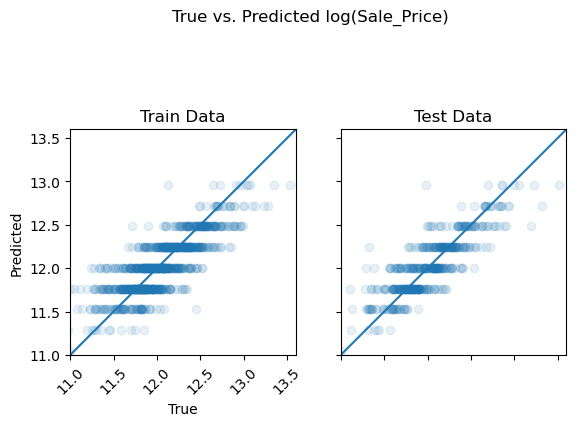

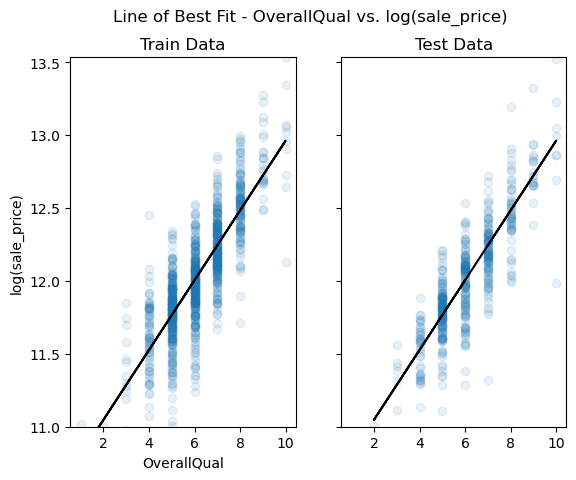

In [11]:
from helper_functions import plot_model_predictions 
(fig1, fig2) = plot_model_predictions(predictor=predictor,
                                      x_train=x_train, x_test=x_test,
                                      y_train=y_train, y_test=y_test,
                                      y_pred_train=y_pred_train, y_pred_test=y_pred_test,
                                      logTransformY=True);

# print(type(fig1))
import matplotlib.pyplot as plt
import pylab as pl
pl.figure(fig1.number)
plt.savefig('..//fig//regression//univariate_truePrice_vs_predPrice.png',bbox_inches='tight', dpi=300)
pl.figure(fig2.number)
plt.savefig('..//fig//regression//univariate_x_vs_predPrice.png',bbox_inches='tight', dpi=300)


<img src="../fig/regression/univariate_truePrice_vs_predPrice.png"  align="left" width="40%" height="40%">
<img src="../fig/regression/univariate_x_vs_predPrice.png"  align="center" width="40%" height="40%">

#### EXERCISE_START: Inspect the plots
1. Does the model capture the variability in sale prices well? Would you use this model to predict the sale price of a house? Why or why not?

2. Does the model seem to exhibit any signs of overfitting? What about underfitting?

3. How might you improve the model?

#### EXERCISE_SOLUTION
1. Based on visual inspection, this linear model does a fairly good job in capturing the relationship between "OverallQual" and sale price. While sales price appears to follow a predictable trend, it may be best to first quantitatively evaluate the model before overrelying on its predictions.

2. Since the train and test set plots look very similar, overfitting is not a concern. Generally speaking, overfitting is not encountered with univariate models unless you have an incredily small number of samples to train the model on. Since the model follows the trajectory of sale price reasonably well, it also does not appear to underfit the data (at least not to an extreme extent).

3. In order to improve this model, we can ask ourselves — is "OverallQual" likely the only variable that contributes to final sale price, or should we consider additional predictor variables? Most outcome variables can be influenced by more than one predictor variable. By accounting for all predictors that have an impact on sales price, we can improve the model.

#### EXERCISE_END

#### 5) Measure model error and assess under/overfitting
While qualitative examinations of model performance are extremely helpful, it is always a good idea to pair such evaluations with a quantitative analysis of the model's performance.

**Convert back to original data scale**  
There are several error measurements that can't be used to measure a regression model's performance. Before we implement any of them, we'll first convert the log(salePrice) back to original sale price for ease of interpretation.

In [12]:
salePrice_train = np.exp(y_train)
pred_salePrice_train = np.exp(y_pred_train)

salePrice_test = np.exp(y_test)
pred_salePrice_test = np.exp(y_pred_test)

**Measure baseline performance**

In [40]:
from math import sqrt
import pandas as pd

mean_sale_price = y.mean()
print('mean sale price =', mean_sale_price)

# convert to series same length as y sets for ease of comparison
mean_sale_price = pd.Series(mean_sale_price) 
mean_sale_price = mean_sale_price.repeat(len(y))

# mean_sale_price_test = pd.Series(mean_sale_price)
# mean_sale_price_test = mean_sale_price_test.repeat(len(salePrice_test))

mean sale price = 180921.19589041095


**Root Mean Squared Error (RMSE)**:
The RMSE provides an easy-to-interpret number that represents error in terms of the units of the target variable. With our univariate model, the "YearBuilt" predictor variable (a.k.a. model feature) predicts sale prices within +/- $68,106 from the true sale price. We always use the RMSE of the test set to assess the model's ability to generalize on unseen data. An extremely low prediction error in the train set is also a good indicator of overfitting.

In [41]:
from sklearn import metrics

RMSE_baseline = metrics.mean_squared_error(y, mean_sale_price, squared=False) 
RMSE_train = metrics.mean_squared_error(salePrice_train, pred_salePrice_train, squared=False) 
RMSE_test = metrics.mean_squared_error(salePrice_test, pred_salePrice_test, squared=False) 

print(f"Baseline RMSE = {RMSE_baseline}")
print(f"Train RMSE = {RMSE_train}")
print(f"Test RMSE = {RMSE_test}")

Baseline RMSE = 79415.29188606751
Train RMSE = 45534.34940950763
Test RMSE = 44762.77229823455


Here, both train and test RMSE are very similar to one another. As expected with most univariate models, we do not see any evidence of overfitting. However, we do see that our model is perhaps underfitting given its poor ability to predict any of the true housing prices.

**Mean Absolute Percentage Error**:
What if we wanted to know the percent difference between the true sale price and the predicted sale price? For this, we can use the **mean absolute percentage error (MAPE)**...

In [43]:
MAPE_baseline = metrics.mean_absolute_percentage_error(y, mean_sale_price) 
MAPE_train = metrics.mean_absolute_percentage_error(salePrice_train, pred_salePrice_train) 
MAPE_test = metrics.mean_absolute_percentage_error(salePrice_test, pred_salePrice_test) 
print(f"Baseline MAPE = {MAPE_baseline*100}")
print(f"Train MAPE = {MAPE_train*100}")
print(f"Test MAPE = {MAPE_test*100}")

Baseline MAPE = 36.3222261212389
Train MAPE = 18.75854039670096
Test MAPE = 16.753971728816907


With the MAPE measurement (max value of 1 which corresponds to 100%), we can state that our model over/under estimates sale prices by an average of 23.41% (25.28%) across all houses included in the test set (train set). Certainly seems there is room for improvement based on this measure.

**R-Squared**: Another useful error measurement to use with regression models is the coefficient of determination — $R^2$. Oftentimes pronounced simply "R-squared",  this measure assesses the proportion of the variation in the target variable that is predictable from the predictor variable(s). Using sklearn's metrics, we can calculate this as follows:

In [44]:
R2_baseline = metrics.r2_score(y, mean_sale_price) 
R2_train = metrics.r2_score(y_train, y_pred_train) 
R2_test = metrics.r2_score(y_test, y_pred_test) 
print(f"Baseline R-squared = {R2_baseline}")
print(f"Train R-squared = {R2_train}")
print(f"Test R-squared = {R2_test}")


Baseline R-squared = 0.0
Train R-squared = 0.6521389099611015
Test R-squared = 0.7012721408788911


Our model predicts 70.1% (65.2%) of the variance across sale prices in the test set (train set).

To read more about additional error/loss measurements, visit [sklearn's metrics documentation](https://scikit-learn.org/stable/modules/model_evaluation.html).

#### EXERCISE_START: More on R-squared
Our above example model is able to explain roughly 70.1% of the variance in the test dataset. Is this a “good” value for R-squared?

**Hint**: The answer to this question depends on your objective for the regression model. This relates back to the two modeling goals of *explaining* vs *predicting*. Depending on the objective, the answer to "What is a good value for R-squared?" will be different.

#### EXERCISE_SOLUTION

**Explaining the relationship between the predictor(s) and the response Variable**
If your main objective for your regression model is to explain the relationship(s) between the predictor(s) and the response variable, the R-squared is mostly irrelevant. A predictor variable that consistently relates to a change in the response variable (i.e., has a statistically significant effect) is typically always interesting — regardless of the the effect size. 

**Predicting the response variable**
If your main objective is to predict the value of the response variable accurately using the predictor variable, then R-squared is important. The value for R-squared can range from 0 to 1. A value of 0 indicates that the response variable cannot be explained by the predictor variable at all. A value of 1 indicates that the response variable can be perfectly explained without error by the predictor variable. In general, the larger the R-squared value, the more precisely the predictor variables are able to predict the value of the response variable. How high an R-squared value needs to be depends on how precise you need to be for your specific model's application. To find out what is considered a “good” R-squared value, you will need to explore what R-squared values are generally accepted in your particular field of study.

#### EXERCISE_END

#### EXERCISE_START: Determine which single variable is most predictive of housing prices
Given a high-dimensional dataset, one potential direciton of inquiry is to ask — which single variable is most predictive of sales price?

#### EXERCISE_SOLUTION

#### EXERCISE_END

#### 7) Explaining model predictions using statistics
At this point, we have assessed the predictive accuracy of our model. However, what if we want to make scientific claims regarding whether or not a single predictor has a consistent or above chance (i.e., statistically significant) impact sales price? For this kind of question, we need to incorporate statistical analyses after fitting our model. This next section will explore the assumptions required for running basic statistics on a linear regression model.